This notebook consists of training various Autoencoder Architectures step-by-step. The structure:
- Autoencoders without temporal encodings
    1. 2D_AE: Autoencoder with 3D Convolution on H,W,T
    2. 3D_AE: Autoencoder with 2D Convolution where temporal images are passed as extra channels 
    3. 3D_VAE: Variational Autoencoder with 3D Convolution on H,W,T
- Autoencoders without temporal encodings
    1. Autoencoder with 3D Convolution and Acquition dates as sin-cos embedding channels (extra channels=2)
    2. Autoencoder with 3D Convolution and Acquition dates as sin-cos embeddings which are added to the data tensor in the forward function
    3. Autoencoder with 2D Convolution and Acquition dates as sin-cos embeddings which are added to the data tensor in the forward function
- Results comparison
- Hyperparameter selection experiments using k-fold cross validation

All of the models are run 3 times, and the average metrics are compared. 
We also experiment with different training hyperparameters, and select the suitable ones.

IMPORTANT NOTE: To skip training the models, just run the imports cells and go dierctly to **'Results Comparison'** section to see the results.

All results and trained models are already saved at the path: *Modeling/Results*

## Imports

In [ ]:
%load_ext autoreload
%autoreload 2
import os, sys
from pathlib import Path

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('/home/k64835/Master-Thesis-SITS')  # change according to the system path

scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Evaluation/").resolve()
sys.path.append(str(scripts_path))

In [ ]:
import pickle
import time
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
from sklearn.manifold import TSNE 
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from model_scripts.subpatch_extraction import *
from Experimentation.expt_scripts.expt_plots import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.model_helper import *
from model_scripts.dataset_creation import *
from model_scripts.executions import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from model_scripts.clustering import *
from evaluation_scripts.evaluation_helper import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
from Experimentation.expt_scripts.expt_plots import *
from Pipeline.preprocess_script import *
import numpy as np
import config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

## Autoencoders without temporal encodings

### Dataset prep

Dimensions: (N, T, C, H, W) = (N, 7, 10, 4, 4)

In [ ]:
dataloader_train, dataloader_test, dataloader_eval = get_model_ready_data(model_type='autoencoders', tensor_type='b10_add', encoding_method='sin-cos', visualisation_images=False)

### Architectures

#### 2D_AE

In [34]:
class Conv3DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels
        self.patch_size = patch_size

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size * time_steps, 512)   
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size * time_steps)

        # --- 3D Deconvolutions (Transpose convolutions) ---
        self.unflatten = nn.Unflatten(1, (256, time_steps, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)


    def forward(self, x):
        
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        b, c, t, h, w = x.shape                 # (B, C, T, H, W)
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        z = self.fc2(x)                         # Bottleneck    

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- Reshape and 3D Deconvolutions ---
        x = self.unflatten(x)                   # (B, C, H, W, T)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)       # Reconstruction

        return z, x_reconstructed

In [35]:
device = 'cuda'
latent_dim = 32
channels = 10
time_steps = 7
patch_size = config.subpatch_size

model_3D_AE = Conv3DAutoencoder(channels, time_steps, latent_dim, patch_size)
device = torch.device(device)  
model_3D_AE.to(device)

Conv3DAutoencoder(
  (conv1): Conv3d(10, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=28672, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=28672, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 7, 4, 4))
  (deconv1): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv3): ConvTranspose3d(64, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
)

#### 3D_AE

In [32]:
class Conv2DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv2DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (2D Convolutions, treating time steps as channels) ---
        self.conv1 = nn.Conv2d(in_channels * time_steps, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)

        # --- 2D Deconvolutions ---
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, in_channels * time_steps, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        
        # --- Encoder ---
        b, c, t, h, w = x.shape
        x = x.reshape(b, c * t, h, w)      # Imp: Time steps as additional channels (B, C * D, H, W)
        # print(x.shape)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        z = self.fc2(x)
        # print(x.shape)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- 2D Deconvolutions ---
        x = x.view(b, 256, h, w)        
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        # print(x.shape)

        # --- Reshape to B x C x D x H x W ---
        x_reconstructed = x.view(b, self.in_channels, self.time_steps, h, w) 

        return z, x_reconstructed

In [33]:
device = 'cuda'
latent_dim=32
channels = 10
time_steps = 7
patch_size = config.subpatch_size

model_2D_AE = Conv2DAutoencoder(channels, time_steps, latent_dim, patch_size)
device = torch.device(device)  
model_2D_AE.to(device)

Conv2DAutoencoder(
  (conv1): Conv2d(70, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=4096, bias=True)
  (deconv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv3): ConvTranspose2d(64, 70, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

#### 3D_VAE

In [19]:
class Conv3DVAE(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DVAE, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * time_steps * patch_size * patch_size, 512)
        self.fc_mu = nn.Linear(512, latent_size)
        self.fc_logvar = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * time_steps * patch_size * patch_size)

        # --- 3D Deconvolutions ---
        self.unflatten = nn.Unflatten(1, (256, time_steps, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)

        # --- Reparameterization Trick ---
        z = self.reparameterize(mu, log_var)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- Reshape for 3D Deconvolutions ---
        x = self.unflatten(x)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)

        return mu, log_var, z, x_reconstructed


In [20]:
device = 'cuda'
latent_dim=32
channels = 10
time_steps = 7
patch_size = config.subpatch_size

model_3D_VAE = Conv3DVAE(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
model_3D_VAE.to(device)

Conv3DVAE(
  (conv1): Conv3d(10, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=28672, out_features=512, bias=True)
  (fc_mu): Linear(in_features=512, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=28672, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 7, 4, 4))
  (deconv1): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv3): ConvTranspose3d(64, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
)

### Training

In [68]:
optimizer='SGD'
epochs = 50
momentum=0.9
lr = 0.01
vae_optimizer='Adam'
vae_lr = 0.0001
device = 'cuda'

In [72]:
model_names = ["3D_AE","2D_AE"]
model_objs = [Conv3DAutoencoder, Conv2DAutoencoder]  # Replace with your model constructors
train_loss = {}
test_loss = {}
metrics = {}

for name, obj in zip(model_names, model_objs):
    avg_train_loss, avg_test_loss, avg_metrics = train_model_multiple_runs_with_metrics(
        model_name=name,
        model_class=obj,
        dataloader_train=dataloader_train,
        dataloader_test=dataloader_test,
        dataloader_eval=dataloader_eval,
        epochs=epochs,
        optimizer=optimizer,
        lr=lr,
        vae_lr=vae_lr,
        vae_optimizer=vae_optimizer,
        momentum=momentum,
        device=device,
        config=config,
        output_dir=config.results_json_path
    )
    train_loss[name] = avg_test_loss
    test_loss[name] = avg_test_loss
    metrics[name] = avg_metrics
    print("Model ",name," trained")


Model  3D_VAE  trained


## Autoencoders with temporal encodings

### Data Prep: Time Embeddings as Channels

Dimensions: (N, T, C, H, W) = (N, 7, 10 + 2, 4, 4)

In [ ]:
dataloader_train, dataloader_test, dataloader_eval = get_model_ready_data(model_type='autoencoders_channel', tensor_type='b10_channel', encoding_method='sin-cos', visualisation_images=False)

### Data Prep: Time Embeddings Addition in Encoder

Dimensions: (N, T, C, H, W) = (N, 7, 10, 4, 4)

In [ ]:
dataloader_train, dataloader_test, dataloader_eval = get_model_ready_data(model_type='autoencoders_addition', tensor_type='b10_add', encoding_method='sin-cos', visualisation_images=False)

### Architecture

#### 3D_AE temporal encodings channel

In [15]:
class Conv3DAutoencoder_Time_Channel(nn.Module):
    def __init__(self, in_channels, out_channels, time_steps, latent_size, patch_size):
        super(Conv3DAutoencoder_Time_Channel, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels
        self.patch_size = patch_size

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size * time_steps, 512)   
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size * time_steps)

        # --- 3D Deconvolutions (Transpose convolutions) ---
        self.unflatten = nn.Unflatten(1, (256, time_steps, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, out_channels, kernel_size=3, stride=1, padding=1)


    def forward(self, x):
        
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        b, c, t, h, w = x.shape                 # (B, C, T, H, W)
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        z = self.fc2(x)                         # Bottleneck    

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- Reshape and 3D Deconvolutions ---
        x = self.unflatten(x)                   # (B, C, H, W, T)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)       # Reconstruction

        return z, x_reconstructed

#### 3D_AE temporal encodings addition

In [22]:
class Conv3DAutoencoder_Time_Addition(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DAutoencoder_Time_Addition, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels
        self.patch_size = patch_size

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size * time_steps, 512)   
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size * time_steps)

        # --- 3D Deconvolutions (Transpose convolutions) ---
        self.unflatten = nn.Unflatten(1, (256, time_steps, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)

        # --- Temporal embedding projection to match channels (needed for alignment) ---
        self.temb_proj = nn.Conv3d(2, in_channels, kernel_size=1)


    def forward(self, x, date_embeddings):

        # --- Date embedding processing ---
        # Convert the date embeddings to the shape (B, 2, 7, 4, 4)
        if not isinstance(date_embeddings, torch.Tensor):
            date_embeddings = torch.tensor(date_embeddings, dtype=torch.float32).to(x.device)
        else:
            date_embeddings = date_embeddings.to(x.device)
        date_embeddings_tensor = date_embeddings.permute(0, 2, 1)                                # Shape: (B, 2, 7)
        date_embeddings_tensor = date_embeddings_tensor.unsqueeze(-1).unsqueeze(-1)                     # Shape: (B, 2, 7, 1, 1)
        date_embeddings_tensor = date_embeddings_tensor.expand(-1, -1, -1, x.shape[3], x.shape[4])      # Shape: (B, 2, 7, 4, 4)

        # Project the date embeddings to match the channels
        date_embeddings_tensor = self.temb_proj(date_embeddings_tensor)                                 # Shape: (B, 10, 7, 4, 4)
        # print('x shape before time embedding:',x.shape)
        # print('time embeddings:',date_embeddings_tensor.shape)
        
        # --- Add date embeddings to the input tensor ---
        x = x + date_embeddings_tensor                                                                  # Shape: (B, 10, 7, 4, 4)
        # print('x shape after time embedding',x.shape)
        
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        b, c, t, h, w = x.shape                 # (B, C, T, H, W)
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        z = self.fc2(x)                         # Bottleneck    

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- Reshape and 3D Deconvolutions ---
        x = self.unflatten(x)                   # (B, C, H, W, T)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)       # Reconstruction

        return z, x_reconstructed

#### 2D_AE temporal encodings addition

In [ ]:
class Conv2DAutoencoder_Time_Addition(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv2DAutoencoder_Time_Addition, self).__init__()

        self.in_channels = in_channels
        self.time_steps = time_steps
        self.patch_size = patch_size

        # --- Temporal embedding projection to match input shape before flattening ---
        self.temb_proj = nn.Conv3d(2, in_channels, kernel_size=1)  # from (B, 2, T, H, W) to (B, C, T, H, W)

        # --- Encoder ---
        self.conv1 = nn.Conv2d(in_channels * time_steps, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)

        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, in_channels * time_steps, kernel_size=3, stride=1, padding=1)

    def forward(self, x, date_embeddings):
        b, c, t, h, w = x.shape  # (B, C, T, H, W)

        # --- Process date embeddings ---
    
        if not isinstance(date_embeddings, torch.Tensor):
            date_embeddings = torch.tensor(date_embeddings, dtype=torch.float32).to(x.device)
        else:
            date_embeddings = date_embeddings.to(x.device)

        temb = date_embeddings.permute(0, 2, 1).unsqueeze(-1).unsqueeze(-1)  # (B, 2, T, 1, 1)
        temb = temb.expand(-1, -1, -1, h, w)                                 # (B, 2, T, H, W)
        temb = self.temb_proj(temb)                                         # (B, C, T, H, W)

        # --- Add temporal encodings ---
        x = x + temb                                                        # (B, C, T, H, W)

        # --- Reshape for 2D conv (treat time as channel) ---
        x = x.reshape(b, c * t, h, w)                                       # (B, C*T, H, W)

        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Latent bottleneck ---
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        z = self.fc2(x)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))
        x = x.view(b, 256, h, w)

        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)

        x_reconstructed = x.view(b, self.in_channels, self.time_steps, h, w)  # Reshape back

        return z, x_reconstructed


### Training

#### 3D_AE temporal enconding channels

In [9]:
device = 'cuda'
epochs = 50
lr = 0.001
vae_lr=0.001
latent_dim = 32
in_channels = 12
momentum=0.9
out_channels = 10
time_steps = 7
optimizer = 'Adam'
vae_optimizer = 'Adam'
patch_size = config.subpatch_size

In [ ]:
model_names = ["3D_AE_temporal_channel"]
model_objs = [Conv3DAutoencoder_Time_Channel]  
train_loss = {}
test_loss = {}
metrics = {}

for name, obj in zip(model_names, model_objs):
    avg_train_loss, avg_test_loss, avg_metrics = train_model_multiple_runs_with_metrics(
        model_name=name,
        model_class=obj,
        dataloader_train=dataloader_train_ch,
        dataloader_test=dataloader_test_ch,
        dataloader_eval=dataloader_eval_ch,
        epochs=epochs,
        optimizer=optimizer,
        lr=lr,
        vae_lr=vae_lr,
        vae_optimizer=vae_optimizer,
        momentum=momentum,
        device=device,
        config=config,
        output_dir=config.results_json_path
    )
    print("Model ",name," trained")


Model  3D_AE_temporal_channel  trained


#### 3D_AE temporal enconding addition

In [17]:
device = 'cuda'
epochs = 50
momentum=0.9
lr = 0.001
vae_lr=0.001
latent_dim = 32
channels = 10
time_steps = 7
optimizer = 'Adam'
vae_optimizer = 'Adam'
patch_size = config.subpatch_size

In [ ]:
model_names = ["3D_AE_temporal_addition"]
model_objs = [Conv3DAutoencoder_Time_Addition]  
train_loss = {}
test_loss = {}
metrics = {}

for name, obj in zip(model_names, model_objs):
    avg_train_loss, avg_test_loss, avg_metrics = train_model_multiple_runs_with_metrics(
        model_name=name,
        model_class=obj,
        dataloader_train=dataloader_train_add,
        dataloader_test=dataloader_test_add,
        dataloader_eval=dataloader_eval_add,
        channels=channels,
        timestamps=time_steps,
        epochs=epochs,
        optimizer=optimizer,
        lr=lr,
        vae_lr=vae_lr,
        vae_optimizer=vae_optimizer,
        momentum=momentum,
        device=device,
        config=config,
        output_dir=config.results_json_path
    )
    print("Model ",name," trained")


Model  3D_AE_temporal_addition  trained


#### 2D_AE temporal enconding addition

In [9]:
device = 'cuda'
epochs = 50
momentum=0.9
lr = 0.001
vae_lr=0.001
latent_dim = 32
channels = 10
time_steps = 7
optimizer = 'Adam'
vae_optimizer = 'Adam'
patch_size = config.subpatch_size

In [10]:
model_names = ["2D_AE_temporal_addition"]
model_objs = [Conv2DAutoencoder_Time_Addition]  
train_loss = {}
test_loss = {}
metrics = {}

for name, obj in zip(model_names, model_objs):
    avg_train_loss, avg_test_loss, avg_metrics = train_model_multiple_runs_with_metrics(
        model_name=name,
        model_class=obj,
        dataloader_train=dataloader_train_add,
        dataloader_test=dataloader_test_add,
        dataloader_eval=dataloader_eval_add,
        channels=channels,
        timestamps=time_steps,
        epochs=epochs,
        optimizer=optimizer,
        lr=lr,
        vae_lr=vae_lr,
        vae_optimizer=vae_optimizer,
        momentum=momentum,
        device=device,
        config=config,
        output_dir=config.results_json_path
    )
    print("Model ",name," trained")


Model  2D_AE_temporal_addition  trained


## Results Comparison

In [11]:
model_names = ['2D_AE',"2D_AE_temporal_addition",'3D_AE',"3D_AE_temporal_channel","3D_AE_temporal_addition"]
df_loss, df_accuracy, df_recall, df_f1, df_precision = compile_results_table_with_metrics(model_names, output_dir=config.results_json_path)

In [12]:
df_accuracy

,Model,Accuracy Run 1,Accuracy Run 2,Accuracy Run 3,Accuracy Avg
0,2D_AE,55.74,60.66,63.93,60.110000
1,2D_AE_temporal_addition,52.46,63.93,60.66,59.016667
2,3D_AE,60.66,59.02,60.66,59.566667
3,3D_AE_temporal_channel,68.85,70.49,70.49,69.943333
4,3D_AE_temporal_addition,68.85,68.85,70.49,69.396667


In [13]:
df_recall

,Model,Recall Run 1,Recall Run 2,Recall Run 3,Recall Avg
0,2D_AE,77.14,80.00,62.86,73.333333
1,2D_AE_temporal_addition,77.14,94.29,82.86,84.763333
2,3D_AE,80.00,71.43,74.29,72.383333
3,3D_AE_temporal_channel,77.14,82.86,77.14,79.046667
4,3D_AE_temporal_addition,82.86,82.86,77.14,80.953333


In [14]:
df_f1

,Model,F1 Run 1,F1 Run 2,F1 Run 3,F1-score Avg
0,2D_AE,66.67,70.00,66.67,67.780000
1,2D_AE_temporal_addition,65.06,75.00,70.73,70.263333
2,3D_AE,70.00,66.67,68.42,67.253333
3,3D_AE_temporal_channel,73.97,76.32,75.00,75.096667
4,3D_AE_temporal_addition,75.32,75.32,75.00,75.213333


In [11]:
df_precision

,Model,Precision Run 1,Precision Run 2,Precision Run 3,Precision Avg
0,2D_AE,58.70,62.22,70.97,63.963333
1,3D_AE,62.22,62.50,63.41,62.803333
2,3D_VAE,60.53,60.00,61.90,60.810000
3,3D_AE_temporal_channel,71.05,70.73,72.97,71.583333
4,3D_AE_temporal_addition,69.05,69.05,72.97,70.356667


### Loss Plots

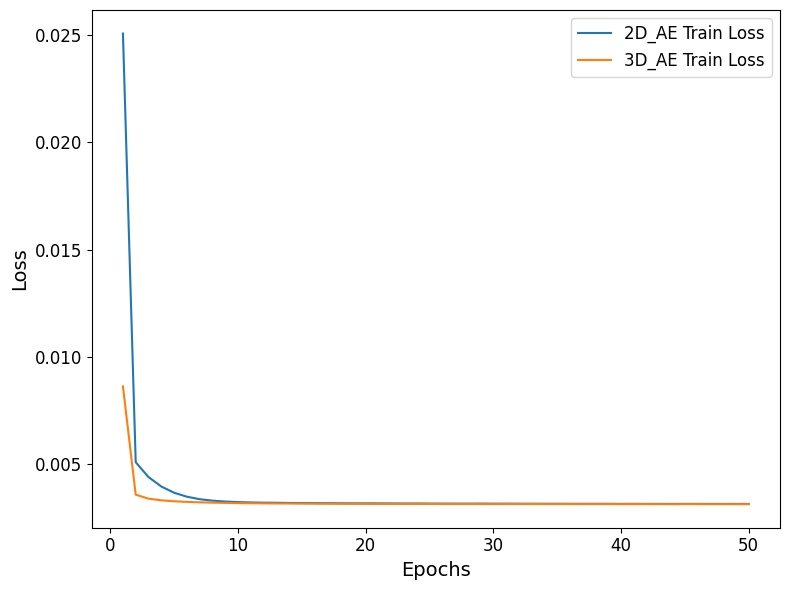

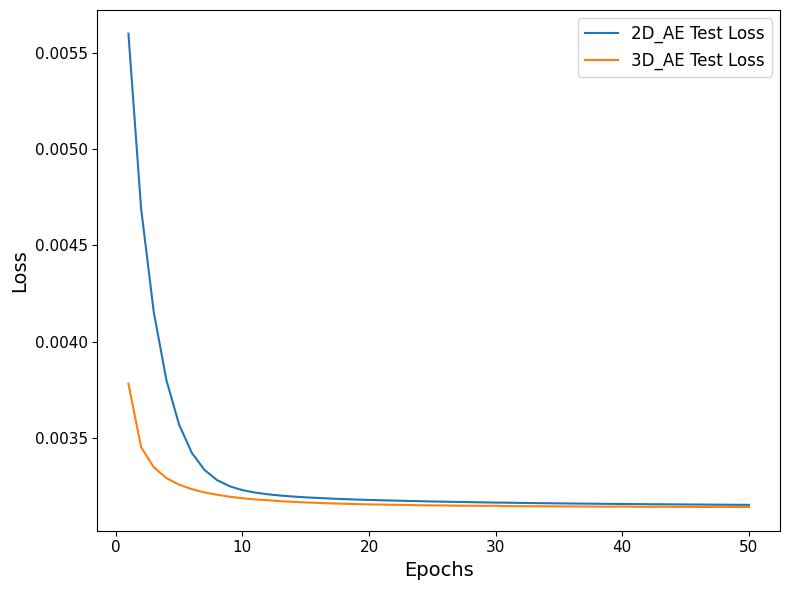

In [15]:
model_names = ['2D_AE','3D_AE']
train_loss, test_loss = load_avg_losses(model_names, output_dir=config.results_json_path)
plot_losses_ae(train_loss, test_loss)

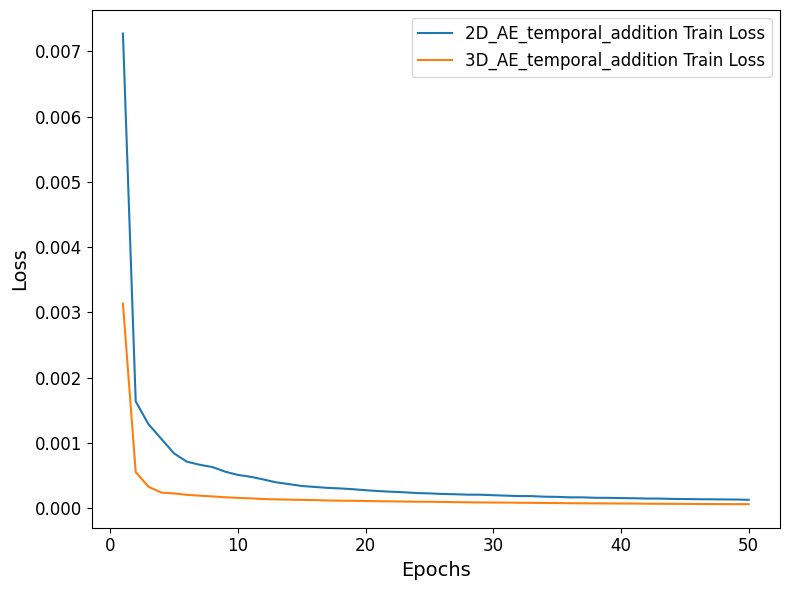

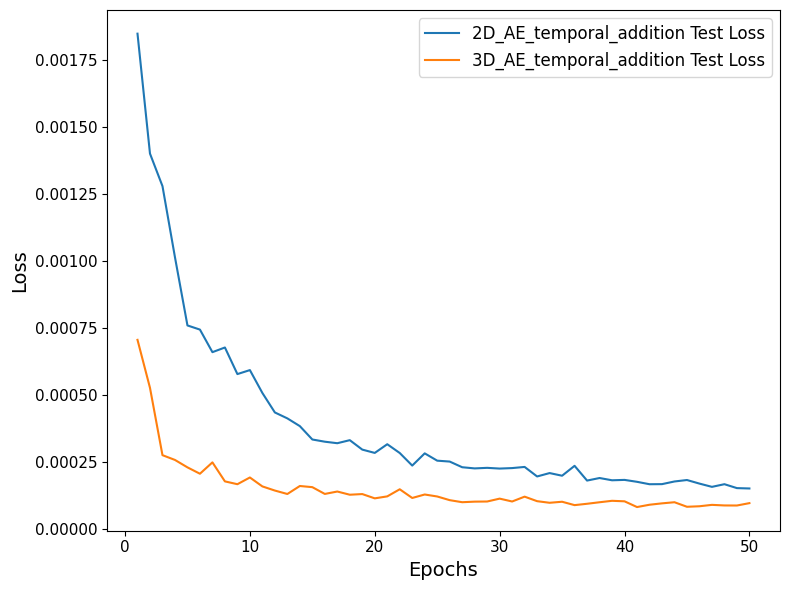

In [14]:
model_names = ['2D_AE_temporal_addition','3D_AE_temporal_addition']
train_loss, test_loss = load_avg_losses(model_names, output_dir=config.results_json_path)
plot_losses_ae(train_loss, test_loss)

## Hyperparameter experiments: k-fold cross validation

### Load sub-patches

Dimensions: (N, T, C, H, W) = (N, 7, 10, 4, 4)

In [ ]:
dataloader_train, dataloader_test, dataloader_eval = get_model_ready_data(model_type='autoencoders_addition', tensor_type='b10_add', encoding_method='sin-cos', visualisation_images=False)

### Architecture

In [8]:
class Conv3DAutoencoder_Time_Addition(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DAutoencoder_Time_Addition, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels
        self.patch_size = patch_size

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size * time_steps, 512)   
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size * time_steps)

        # --- 3D Deconvolutions (Transpose convolutions) ---
        self.unflatten = nn.Unflatten(1, (256, time_steps, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)

        # --- Temporal embedding projection to match channels (needed for alignment) ---
        self.temb_proj = nn.Conv3d(2, in_channels, kernel_size=1)


    def forward(self, x, date_embeddings):

        # --- Date embedding processing ---
        # Convert the date embeddings to the shape (B, 2, 7, 4, 4)
        
        if not isinstance(date_embeddings, torch.Tensor):
            date_embeddings = torch.tensor(date_embeddings, dtype=torch.float32).to(x.device)
        else:
            date_embeddings = date_embeddings.to(x.device)
        date_embeddings_tensor = date_embeddings.permute(0, 2, 1)                                # Shape: (B, 2, 7)
        date_embeddings_tensor = date_embeddings_tensor.unsqueeze(-1).unsqueeze(-1)                     # Shape: (B, 2, 7, 1, 1)
        date_embeddings_tensor = date_embeddings_tensor.expand(-1, -1, -1, x.shape[3], x.shape[4])      # Shape: (B, 2, 7, 4, 4)

        # Project the date embeddings to match the channels
        date_embeddings_tensor = self.temb_proj(date_embeddings_tensor)                                 # Shape: (B, 10, 7, 4, 4)
        # print('x shape before time embedding:',x.shape)
        # print('time embeddings:',date_embeddings_tensor.shape)
        
        # --- Add date embeddings to the input tensor ---
        x = x + date_embeddings_tensor                                                                  # Shape: (B, 10, 7, 4, 4)
        # print('x shape after time embedding',x.shape)
        
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        b, c, t, h, w = x.shape                 # (B, C, T, H, W)
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        z = self.fc2(x)                         # Bottleneck    

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- Reshape and 3D Deconvolutions ---
        x = self.unflatten(x)                   # (B, C, H, W, T)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)       # Reconstruction

        return z, x_reconstructed

### Experimenting with learning rate

In [ ]:
unlabeled_dataset = FieldDatasetMAE(train_subpatches, train_coord_dataloader, train_subpatch_date_emb, True)

model_params= {
    'in_channels':10, 
    'time_steps':7, 
    'latent_size':32,
    'patch_size':config.subpatch_size   
}

avg_error = kfold_train_autoencoder(
    model_class=Conv3DAutoencoder_Time_Addition,
    dataset=unlabeled_dataset,       # PyTorch dataset returning (inputs, field_numbers, date_embeddings)
    modelparams=model_params,
    k=5,
    epochs=50,
    lr=0.01,
    batch_size=64,
    optimizer='Adam',
    device='cuda'
)


Fold 1/5
Fold 1 reconstruction error: 0.002582
Fold 2/5
Fold 2 reconstruction error: 0.002489
Fold 3/5
Fold 3 reconstruction error: 0.002482
Fold 4/5
Fold 4 reconstruction error: 0.002480
Fold 5/5
Fold 5 reconstruction error: 0.002454
Average reconstruction error over 5 folds: 0.002497


### Experimenting with latent size

In [9]:
unlabeled_dataset = FieldDatasetMAE(train_subpatches, train_coord_dataloader, train_subpatch_date_emb, True)

model_params= {
    'in_channels':10, 
    'time_steps':7, 
    'latent_size':16,
    'patch_size':config.subpatch_size   
}

avg_error = kfold_train_autoencoder(
    model_class=Conv3DAutoencoder_Time_Addition,
    dataset=unlabeled_dataset,       # PyTorch dataset returning (inputs, field_numbers, date_embeddings)
    modelparams=model_params,
    k=5,
    epochs=50,
    lr=0.001,
    batch_size=64,
    optimizer='Adam',
    device='cuda'
)


Fold 1/5
Fold 1 reconstruction error: 0.000105
Fold 2/5
Fold 2 reconstruction error: 0.000110
Fold 3/5
Fold 3 reconstruction error: 0.000097
Fold 4/5
Fold 4 reconstruction error: 0.000100
Fold 5/5
Fold 5 reconstruction error: 0.000116
Average reconstruction error over 5 folds: 0.000106


### Experimenting with optimizer

In [10]:
unlabeled_dataset = FieldDatasetMAE(train_subpatches, train_coord_dataloader, train_subpatch_date_emb, True)

model_params= {
    'in_channels':10, 
    'time_steps':7, 
    'latent_size':16,
    'patch_size':config.subpatch_size   
}

avg_error = kfold_train_autoencoder(
    model_class=Conv3DAutoencoder_Time_Addition,
    dataset=unlabeled_dataset,       # PyTorch dataset returning (inputs, field_numbers, date_embeddings)
    modelparams=model_params,
    k=5,
    epochs=50,
    lr=0.001,
    batch_size=64,
    optimizer='SGD',
    device='cuda'
)


Fold 1/5


Fold 1 reconstruction error: 0.002333
Fold 2/5
Fold 2 reconstruction error: 0.002335
Fold 3/5
Fold 3 reconstruction error: 0.002307
Fold 4/5
Fold 4 reconstruction error: 0.002281
Fold 5/5
Fold 5 reconstruction error: 0.002314
Average reconstruction error over 5 folds: 0.002314


### Experimenting Number of epochs

In [11]:
unlabeled_dataset = FieldDatasetMAE(train_subpatches, train_coord_dataloader, train_subpatch_date_emb, True)

model_params= {
    'in_channels':10, 
    'time_steps':7, 
    'latent_size':32,
    'patch_size':config.subpatch_size   
}

avg_error = kfold_train_autoencoder(
    model_class=Conv3DAutoencoder_Time_Addition,
    dataset=unlabeled_dataset,       # PyTorch dataset returning (inputs, field_numbers, date_embeddings)
    modelparams=model_params,
    k=5,
    epochs=30,
    lr=0.001,
    batch_size=64,
    optimizer='Adam',
    device='cuda'
)


Fold 1/5


Fold 1 reconstruction error: 0.000132
Fold 2/5
Fold 2 reconstruction error: 0.000094
Fold 3/5
Fold 3 reconstruction error: 0.000102
Fold 4/5
Fold 4 reconstruction error: 0.000103
Fold 5/5
Fold 5 reconstruction error: 0.000098
Average reconstruction error over 5 folds: 0.000106


### Best combination

In [ ]:
unlabeled_dataset = FieldDatasetMAE(train_subpatches, train_coord_dataloader, train_subpatch_date_emb, True)

model_params= {
    'in_channels':10, 
    'time_steps':7, 
    'latent_size':32,
    'patch_size':config.subpatch_size   
}

avg_error = kfold_train_autoencoder(
    model_class=Conv3DAutoencoder_Time_Addition,
    dataset=unlabeled_dataset,       # PyTorch dataset returning (inputs, field_numbers, date_embeddings)
    modelparams=model_params,
    k=5,
    epochs=50,
    lr=0.001,
    batch_size=64,
    optimizer='Adam',
    device='cuda'
)


Fold 1/5
Fold 1 reconstruction error: 0.000075
Fold 2/5
Fold 2 reconstruction error: 0.000076
Fold 3/5
Fold 3 reconstruction error: 0.000088
Fold 4/5
Fold 4 reconstruction error: 0.000085
Fold 5/5
Fold 5 reconstruction error: 0.000081
Average reconstruction error over 5 folds: 0.000081
